In [1]:
#%load_ext autoreload
#%autoreload 2

from typing import Optional, Sequence
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA


## DATA

In [2]:
spot_df = pd.read_excel("data/USD_SOFR.xlsx", index_col=0, header=0)
#spot_df = spot_df.set_index("Trade Day")
spot_df = spot_df.apply(pd.to_numeric, errors="coerce").dropna()

<Axes: xlabel='Trade Day'>

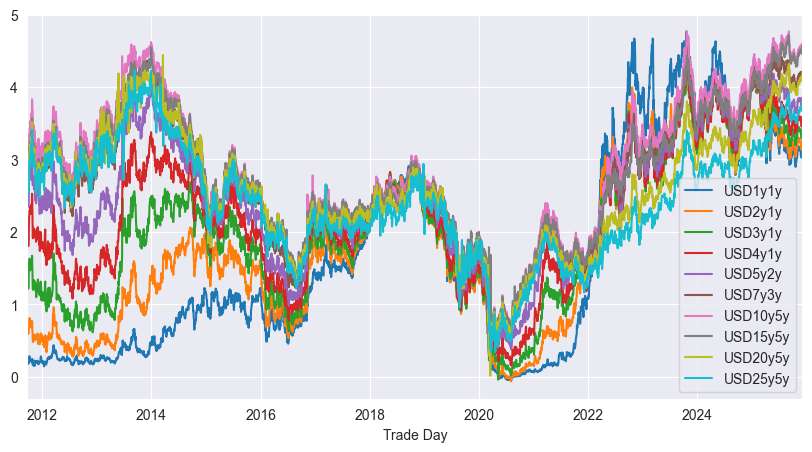

In [24]:
spot_df.plot(figsize=(10, 5))  #, legend=False)

In [4]:
spot_df.describe()

,USD1y1y,USD2y1y,USD3y1y,USD4y1y,USD5y2y,USD7y3y,USD10y5y,USD15y5y,USD20y5y,USD25y5y
count,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000
mean,1.659250,1.794788,2.010089,2.231044,2.478818,2.716395,2.879928,2.788723,2.573313,2.403012
std,1.386136,1.142473,1.006932,0.939022,0.911901,0.929026,0.973755,0.907363,0.829856,0.768799
min,-0.056273,-0.063167,-0.042708,0.154763,0.375781,0.463562,0.433865,0.158579,0.013657,0.338710
25%,0.380718,0.809894,1.160720,1.506065,1.893616,2.117042,2.206742,2.173393,2.056294,1.913189
50%,1.166259,1.631676,1.955757,2.150827,2.420804,2.648229,2.809488,2.711126,2.524812,2.380119
75%,2.955686,2.759737,2.682519,2.903430,3.221298,3.418397,3.656637,3.513088,3.191056,2.959019
max,4.765071,4.418713,4.383288,4.483379,4.574962,4.670857,4.769249,4.709413,4.440674,4.228612


### DROP ILLIQUID TENORS

## PCA

#### Exponential decay

#### Rolling

In [5]:
def rolling_pca(df: pd.DataFrame,
                corr_window_size: int,
                vol_window_size: int,
                recalibration_period: int,
                columns: Optional[Sequence[str]] = None,
                is_diff: bool = True):
    if columns is not None:
        df2 = df[columns].copy()
    else:
        df2 = df.copy()

    n_mats = len(df2.columns)
    n_obs = len(df2)
    pca_collection = {}
    all_loadings = []
    all_scores = []
    all_index = []

    if n_obs < corr_window_size:
        raise ValueError("window_size bigger than number of observations.")
    if vol_window_size > corr_window_size:
        raise ValueError("Volatility window should be smaller than correlation window.")
    if recalibration_period > vol_window_size:
        raise ValueError("Recalibration period should be smaller than volatility window.")

    for i in range(corr_window_size, n_obs, recalibration_period):
        key = df2.index[i].strftime("%Y-%m-%d")
        # using corr window
        X = df2.iloc[i - corr_window_size:i, :].to_numpy()
        corr = np.corrcoef(X.T)  # shape (n_mats, n_mats)
        # using vol window
        vol = np.std(X[corr_window_size - vol_window_size: corr_window_size, :], axis=0, ddof=1)
        mean = np.mean(X[corr_window_size - vol_window_size: corr_window_size, :], axis=0)
        cov = vol.T * corr * vol

        if np.any(~np.isfinite(corr)):
            raise ValueError("Correlation matrix not finite")

        if np.any(~np.isfinite(vol)):
            raise ValueError("Volatility vector not finite")

        U, S, U_transpose = np.linalg.svd(cov)
        explained_variance = S[:3] / S.sum()
        loadings = U[:, :3].T  # first three components; shape (3, n_mats)

        start = i - 1
        end = min(i + recalibration_period - 1, n_obs)
        Y = df2.iloc[start:end, :].to_numpy()

        # make the sign correction based on the training sample X
        sign_correction(loadings=loadings,
                        scores=(X - mean) @ loadings.T,
                        X=X,
                        df=df2)

        # second layer of sign corrections: maximize the similarity with the previous PCA loadings.
        if all_loadings:
            for j in range(3):
                if np.dot(loadings[j, :], all_loadings[-1][j, :]) < 0:
                    loadings[j, :] *= -1

        scores = (Y - mean) @ loadings.T
        # scores = pca.transform(Y)  # shape (recalibration_period, 3)
        score_index = df2.index[start:end]

        all_loadings.append(loadings)
        all_scores.append(scores)
        all_index.extend(score_index)

        pca_collection[key] = {
            "explained_var_ratio": explained_variance,
            "loadings": loadings,
            "mean": mean,
            "vol": vol,
            'cov_matrix': cov,
            "score_index": score_index,
            "scores": scores,
        }

    scores = np.vstack(all_scores)
    scores_df = pd.DataFrame(scores,
                             index=pd.Index(all_index, name="date"),
                             columns=["PC1", "PC2", "PC3"])

    return scores_df, pca_collection


def sign_correction(loadings: np.ndarray,
                    scores: np.ndarray,
                    X: np.ndarray,
                    df: pd.DataFrame):
    """
    Align PCA signs so that PCs have a stable economic meaning.
    Works whether PCA was run on levels or on differences of rates,
    as long as X and df.columns correspond to the same maturities.

    Convention:
      PC1 (level):  positive => higher overall rates (or positive parallel shock)
      PC2 (slope):  positive => steepening (10Y up relative to 2Y)
      PC3 (curv):   positive => more curvature (5Y up vs 2Y/10Y)
    """

    # indices of rates.
    def _find_col(df, candidates):
        for name in candidates:
            if name in df.columns:
                return df.columns.get_loc(name)
        raise KeyError(f"None of {candidates} found in df.columns")

    idx_2y = _find_col(df, ["USD2y1y", "2Y"])
    idx_5y = _find_col(df, ["USD5y2y", "5Y"])
    idx_10y = _find_col(df, ["USD10y5y", "10Y"])

    # PC1: Level
    avg_delta = X.mean(axis=1)  # cross-sectional avg change each day
    if np.corrcoef(scores[:, 0], avg_delta)[0, 1] < 0:
        loadings[0, :] *= -1

    # PC2: Slope
    slope_scores = scores[:, 1]
    short = X[:, idx_2y]
    long = X[:, idx_10y]
    d_spread = long - short  # delta(10Y−2Y)
    if np.corrcoef(slope_scores, d_spread)[0, 1] < 0:
        loadings[1, :] *= -1

    # PC3: Curvature
    curv_scores = scores[:, 2]
    belly = X[:, idx_5y]
    wings = 0.5 * (X[:, idx_2y] + X[:, idx_10y])
    d_curv = belly - wings
    if np.corrcoef(curv_scores, d_curv)[0, 1] < 0:
        loadings[2, :] *= -1

    return None

In [6]:
scores_df, pca_collection = rolling_pca(spot_df,
                                        corr_window_size=90,
                                        vol_window_size=50,
                                        recalibration_period=1)

<Axes: xlabel='date'>

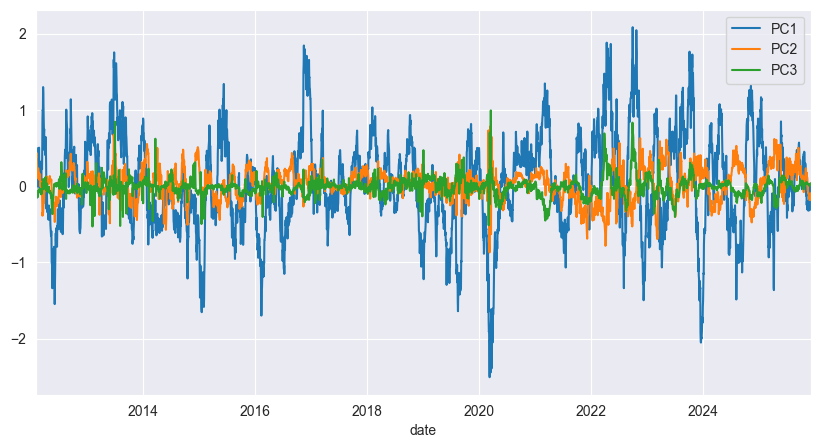

In [35]:
#How far today’s curve level sits along the PC2 shape direction relative to the recent mean.
scores_df.plot(figsize=(10, 5))

<Axes: >

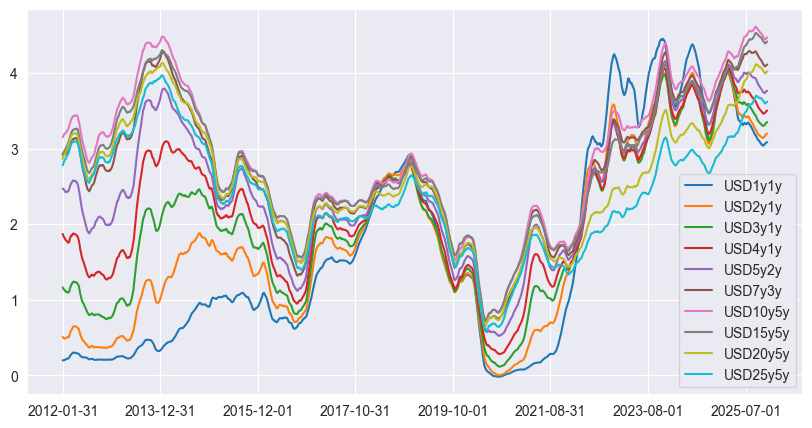

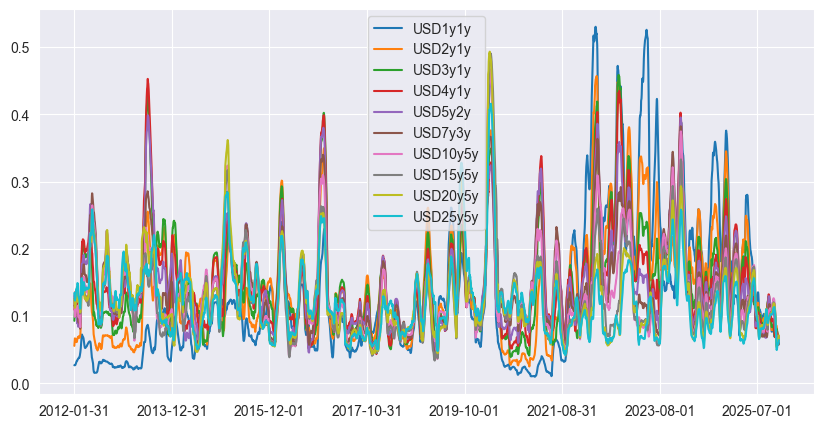

In [27]:
vols = {}
means = {}
for date in pca_collection:
    means[date] = pca_collection[date]['mean']
    vols[date] = pca_collection[date]['vol']  #[list(pca_collection.keys())[-1]]

means_df = pd.DataFrame.from_dict(means).T
means_df.columns = spot_df.columns
means_df.plot(figsize=(10, 5))
vols_df = pd.DataFrame.from_dict(vols).T
vols_df.columns = spot_df.columns
vols_df.plot(figsize=(10, 5))

<Axes: >

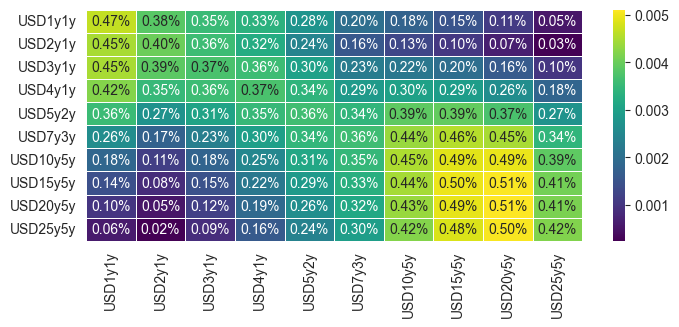

In [28]:
plt.figure(figsize=(8, 3))
sns.heatmap(pd.DataFrame(pca_collection[list(pca_collection.keys())[-1]]['cov_matrix'], columns=list(spot_df.columns),
                         index=list(spot_df.columns)), annot=True, cmap='viridis', fmt=".2%", linewidths=.5)

## Signals

In [ ]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, Optional, Tuple, Callable

#### Util

In [34]:
def to_bp(x: pd.Series | pd.DataFrame) -> pd.Series | pd.DataFrame:
    """Convert rate units to basis points."""
    return x * 1e4


def zscore(s: pd.Series, window: int) -> pd.Series:
    mu = s.rolling(window).mean()
    sd = s.rolling(window).std(ddof=0)
    z_score = (s - mu) / sd
    return z_score.dropna()


def gross_normalize(w: pd.Series) -> pd.Series:
    denom = w.abs().sum()
    if denom == 0 or np.isnan(denom):
        return w * 0.0
    return w / denom


def center_weights(w: pd.Series) -> pd.Series:
    """Remove equal-weight level component in rate space."""
    return w - w.mean()


def safe_corr(a: pd.Series, b: pd.Series, window: int) -> pd.Series:
    return a.rolling(window).corr(b)

#### Mean reversion detector

<Axes: xlabel='date'>

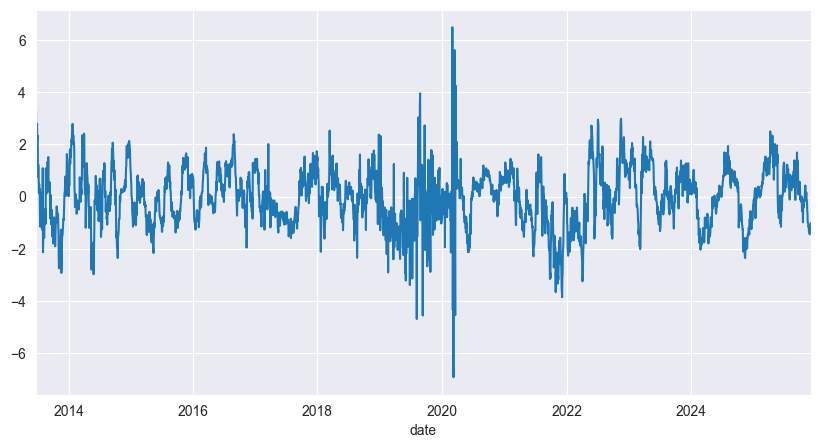

In [33]:
window = 365
#zscore(scores_df['PC1'], window).plot(figsize=(10, 5))
zscore(scores_df['PC2'], window).plot(figsize=(10, 5))

In [36]:
def pc2_mean_reversion_position(scores_df: pd.DataFrame,
                                z_window: int = 60,
                                entry_z: float = 1.5,
                                exit_z: float = 0.3) -> pd.Series:
    pc2 = scores_df["PC2"].copy()
    z = (pc2 - pc2.rolling(z_window).mean()) / pc2.rolling(z_window).std(ddof=0)

    pos = pd.Series(0.0, index=pc2.index)
    current = 0.0

    for t in pc2.index:
        zt = z.loc[t]
        if np.isnan(zt):
            pos.loc[t] = current
            continue

        # exit
        if current != 0 and abs(zt) < exit_z:
            current = 0.0

        # enter
        if current == 0:
            if zt > entry_z:
                current = -1.0  # short PC2
            elif zt < -entry_z:
                current = +1.0  # long PC2

        pos.loc[t] = current

    return pos

#### Momentum detector on PC2

In [37]:
def pc2_momentum_position(scores_df: pd.DataFrame,
                          lookback: int = 20,
                          z_window: int = 60,
                          entry_z: float = 1.0,
                          exit_z: float = 0.0) -> pd.Series:
    pc2 = scores_df["PC2"].copy()

    # Use changes in PC2 score as a proxy for factor "returns"
    d_pc2 = pc2.diff()

    mom = d_pc2.rolling(lookback).sum()
    z = (mom - mom.rolling(z_window).mean()) / mom.rolling(z_window).std(ddof=0)

    pos = pd.Series(0.0, index=pc2.index)
    current = 0.0

    for t in pc2.index:
        zt = z.loc[t]
        if np.isnan(zt):
            pos.loc[t] = current
            continue

        # exit rule
        if current != 0:
            if (current > 0 and zt < exit_z) or (current < 0 and zt > -exit_z):
                current = 0.0

        # entry rule
        if current == 0:
            if zt > entry_z:
                current = +1.0
            elif zt < -entry_z:
                current = -1.0

        pos.loc[t] = current

    return pos


#### Relevance Filter

## Weights

In [ ]:
def build_pc2_weight_df(pca_collection: dict,
                        df_columns: list,
                        center_weights: bool = True,
                        gross_norm: bool = True,
                        drop_first_day_each_block: bool = True) -> pd.DataFrame:
    blocks = []

    for key, item in pca_collection.items():
        loadings = item["loadings"]  # (3, n_mats)
        score_index = item["score_index"]

        v2 = pd.Series(loadings[1, :], index=df_columns).copy()

        if center_weights:
            v2 = center(v2)

        if gross_norm:
            v2 = gross_normalize(v2)

        idx = score_index[1:] if (drop_first_day_each_block and len(score_index) > 1) else score_index

        block = pd.DataFrame([v2.values] * len(idx), index=idx, columns=df_columns)
        blocks.append(block)

    if not blocks:
        return pd.DataFrame(columns=df_columns)

    W = pd.concat(blocks).sort_index()
    W = W[~W.index.duplicated(keep="last")]
    return W


# -------------------------
# Fixed archetype baskets
# -------------------------

def level_basket(columns: list) -> pd.Series:
    w = pd.Series(1.0, index=columns)
    return gross_normalize(w)


def slope_pair_basket(columns: list, short: str, long: str) -> pd.Series:
    w = pd.Series(0.0, index=columns)
    if short in columns and long in columns:
        w[short] = +1.0
        w[long] = -1.0
    return gross_normalize(w)


def build_fixed_weight_df(columns: list, index: pd.Index, w: pd.Series) -> pd.DataFrame:
    w = w.reindex(columns).fillna(0.0)
    return pd.DataFrame([w.values] * len(index), index=index, columns=columns)

## PnL

In [40]:
def pc2_bp_pnl(df_rates_or_diffs: pd.DataFrame,
               W_pc2: pd.DataFrame,
               position: pd.Series) -> pd.Series:
    """
    P&L in bp-space:
      pnl_t = position_{t-1} * sum_i w_{t,i} * Δr_{t,i}
    """
    X = df_rates_or_diffs.copy().sort_index()
    W = W_pc2.copy().sort_index()
    pos = position.copy().sort_index()

    # If X looks like levels, convert to daily changes
    # crude heuristic: if median abs daily change is tiny relative to level magnitude,
    # the user likely passed levels.
    if X.diff().abs().median().median() < 0.2 * X.abs().median().median():
        dR = X.diff()
    else:
        dR = X

    dR = dR.dropna()

    idx = dR.index.intersection(W.index).intersection(pos.index)
    dR = dR.loc[idx]
    W = W.loc[idx]
    pos = pos.loc[idx]

    pos_lag = pos.shift(1).fillna(0.0)

    pnl_rate = (W * dR).sum(axis=1)
    pnl_bp = pnl_rate * 1e4 * pos_lag

    return pnl_bp


In [ ]:
def backtest_oos_bp(levels_df: pd.DataFrame,
                    W: pd.DataFrame,
                    position: pd.Series) -> pd.Series:
    levels = levels_df.sort_index()
    dR = levels.diff().dropna()

    W = W.sort_index()
    pos = position.sort_index()

    idx = dR.index.intersection(W.index).intersection(pos.index)
    dR = dR.loc[idx]
    W = W.loc[idx]
    pos = pos.loc[idx]

    # lag to avoid lookahead
    W_lag = W.shift(1).fillna(0.0)
    pos_lag = pos.shift(1).fillna(0.0)

    pnl_rate = (W_lag * dR).sum(axis=1)
    pnl_bp = pnl_rate * 1e4 * pos_lag

    return pnl_bp

## CONFIG

In [ ]:
# PCA configs to compare
pca_param_grid = [{"corr_window_size": 252, "vol_window_size": 60, "recalibration_period": 5},
                  {"corr_window_size": 504, "vol_window_size": 60, "recalibration_period": 5},
                  {"corr_window_size": 252, "vol_window_size": 40, "recalibration_period": 5}]

# Signal configs to compare
signal_param_grid = [{"signal_type": "pc2_mr", "z_window": 60, "entry_z": 1.5, "exit_z": 0.3},
                     {"signal_type": "pc2_mr", "z_window": 120, "entry_z": 1.8, "exit_z": 0.4},
                     {"signal_type": "pc2_mom", "lookback": 10, "z_window": 60, "entry_z": 1.0, "exit_z": 0.0},
                     {"signal_type": "pc2_mom", "lookback": 20, "z_window": 60, "entry_z": 1.0, "exit_z": 0.0}]

# Positionings to compare
positionings = [{"name": "PC2 Dynamic", "type": "pc2_dynamic"},
                {"name": "Level Fixed", "type": "level_fixed"},
                {"name": "2s10s Fixed", "type": "slope_fixed", "short": "2Y", "long": "10Y"},
                {"name": "5s30s Fixed", "type": "slope_fixed", "short": "5Y", "long": "30Y"}]


#### Util

In [ ]:
def gross_normalize(w: pd.Series) -> pd.Series:
    d = w.abs().sum()
    return w * 0.0 if d == 0 else w / d


def center(w: pd.Series) -> pd.Series:
    return w - w.mean()


def zscore(s: pd.Series, w: int) -> pd.Series:
    mu = s.rolling(w).mean()
    sd = s.rolling(w).std(ddof=0)
    return (s - mu) / sd


def perf_summary_bp(pnl_bp: pd.Series) -> dict:
    pnl = pnl_bp.dropna()
    if len(pnl) == 0:
        return dict(mean_bp=np.nan, vol_bp=np.nan, sharpe_like=np.nan, cum_bp=0.0, turnover=np.nan)

    mean_bp = pnl.mean()
    vol_bp = pnl.std(ddof=0)
    sharpe_like = mean_bp / vol_bp if vol_bp != 0 else np.nan
    cum_bp = pnl.sum()

    return dict(mean_bp=mean_bp, vol_bp=vol_bp, sharpe_like=sharpe_like, cum_bp=cum_bp)


def turnover_proxy(position: pd.Series) -> float:
    # fraction of days position changes (simple proxy)
    pos = position.fillna(0.0)
    changes = (pos != pos.shift(1)).sum()
    return changes / max(len(pos), 1)

## RUN TEST

In [ ]:
def run_strategy_lab(levels_df: pd.DataFrame,
                     pca_param_grid: list,
                     signal_param_grid: list,
                     positionings: list) -> pd.DataFrame:
    """
    pca_param_grid: list of dicts with corr_window_size, vol_window_size, recalibration_period
    signal_param_grid: list of dicts with signal_type and parameters
    positionings: list of dicts defining:
        - name
        - type: "pc2_dynamic" | "slope_fixed" | "level_fixed"
        - optional short/long for slope
    """

    results = []

    for pca_params in pca_param_grid:
        scores_df, pca_collection = rolling_pca(df=levels_df,
                                                corr_window_size=pca_params["corr_window_size"],
                                                vol_window_size=pca_params["vol_window_size"],
                                                recalibration_period=pca_params["recalibration_period"],
                                                columns=pca_params.get("columns", None),
                                                is_diff=False)

        cols_used = list(levels_df.columns if pca_params.get("columns") is None else pca_params["columns"])

        # dynamic PC2 weights for this PCA config
        W_pc2 = build_pc2_weight_df(pca_collection,
                                    df_columns=cols_used,
                                    center_weights=True,
                                    gross_norm=True,
                                    drop_first_day_each_block=True)

        # align weights to full column set for safe multiplication
        W_pc2 = W_pc2.reindex(columns=levels_df.columns).fillna(0.0)

        # precompute fixed weights aligned to PC2 weight dates to keep comparison fair
        weight_index = W_pc2.index if len(W_pc2) else scores_df.index

        W_level_fixed = build_fixed_weight_df(list(levels_df.columns),
                                              weight_index,
                                              level_basket(list(levels_df.columns))
                                              )

        # slope fixed example; you can provide different pairs via positionings
        # We'll build per positioning below.

        for sig_params in signal_param_grid:
            sig_type = sig_params["signal_type"]

            if sig_type == "pc2_mr":
                pos = pc2_mean_reversion_position(scores_df,
                                                  z_window=sig_params.get("z_window", 60),
                                                  entry_z=sig_params.get("entry_z", 1.5),
                                                  exit_z=sig_params.get("exit_z", 0.3)
                                                  )
            elif sig_type == "pc2_mom":
                pos = pc2_momentum_position(scores_df,
                                            lookback=sig_params.get("lookback", 20),
                                            z_window=sig_params.get("z_window", 60),
                                            entry_z=sig_params.get("entry_z", 1.0),
                                            exit_z=sig_params.get("exit_z", 0.0)
                                            )
            else:
                raise ValueError(f"Unknown signal_type: {sig_type}")

            for posdef in positionings:
                pname = posdef["name"]
                ptype = posdef["type"]

                if ptype == "pc2_dynamic":
                    W = W_pc2

                elif ptype == "level_fixed":
                    W = W_level_fixed

                elif ptype == "slope_fixed":
                    short = posdef.get("short")
                    long = posdef.get("long")
                    w_slope = slope_pair_basket(list(levels_df.columns), short=short, long=long)
                    W = build_fixed_weight_df(list(levels_df.columns), weight_index, w_slope)

                else:
                    raise ValueError(f"Unknown positioning type: {ptype}")

                pnl_bp = backtest_oos_bp(levels_df, W, pos)

                summary = perf_summary_bp(pnl_bp)
                summary["turnover"] = turnover_proxy(pos)

                row = {
                    "positioning": pname,
                    "positioning_type": ptype,
                    "signal": sig_type,
                    **{k: v for k, v in pca_params.items() if k != "columns"},
                    **{k: v for k, v in sig_params.items() if k != "signal_type"},
                    **summary
                }
                results.append(row)

    out = pd.DataFrame(results)

    # Nice sorting
    sort_cols = ["sharpe_like", "cum_bp"]
    out = out.sort_values(sort_cols, ascending=[False, False])

    return out


In [ ]:
cols_to_show = ["positioning", "signal",
                "corr_window_size", "vol_window_size", "recalibration_period",
                "z_window", "entry_z", "exit_z", "lookback",
                "mean_bp", "vol_bp", "sharpe_like", "cum_bp", "turnover"
                ]

In [ ]:
# Run lab
results_df = run_strategy_lab(spot_df, pca_param_grid, signal_param_grid, positionings)

## Extra

In [52]:
import numpy as np
import pandas as pd
from itertools import product


# -------------------------
# Basic helpers
# -------------------------




In [53]:
# PCA configs to compare
pca_param_grid = [
    {"corr_window_size": 252, "vol_window_size": 60, "recalibration_period": 5},
    {"corr_window_size": 504, "vol_window_size": 60, "recalibration_period": 5},
    {"corr_window_size": 252, "vol_window_size": 40, "recalibration_period": 5},
]

# Signal configs to compare
signal_param_grid = [
    {"signal_type": "pc2_mr", "z_window": 60, "entry_z": 1.5, "exit_z": 0.3},
    {"signal_type": "pc2_mr", "z_window": 120, "entry_z": 1.8, "exit_z": 0.4},
    {"signal_type": "pc2_mom", "lookback": 10, "z_window": 60, "entry_z": 1.0, "exit_z": 0.0},
    {"signal_type": "pc2_mom", "lookback": 20, "z_window": 60, "entry_z": 1.0, "exit_z": 0.0},
]

# Positionings to compare
positionings = [
    {"name": "PC2 Dynamic", "type": "pc2_dynamic"},
    {"name": "Level Fixed", "type": "level_fixed"},
    {"name": "2s10s Fixed", "type": "slope_fixed", "short": "2Y", "long": "10Y"},
    {"name": "5s30s Fixed", "type": "slope_fixed", "short": "5Y", "long": "30Y"},
]

# Run lab
results_df = run_strategy_lab(spot_df, pca_param_grid, signal_param_grid, positionings)

# Clean view
cols_to_show = [
    "positioning", "signal",
    "corr_window_size", "vol_window_size", "recalibration_period",
    "z_window", "entry_z", "exit_z", "lookback",
    "mean_bp", "vol_bp", "sharpe_like", "cum_bp", "turnover"
]

print(results_df[[c for c in cols_to_show if c in results_df.columns]].head(50))


    positioning   signal  corr_window_size  vol_window_size  \
16  PC2 Dynamic   pc2_mr               504               60   
9   Level Fixed  pc2_mom               252               60   
0   PC2 Dynamic   pc2_mr               252               60   
4   PC2 Dynamic   pc2_mr               252               60   
25  Level Fixed  pc2_mom               504               60   
20  PC2 Dynamic   pc2_mr               504               60   
36  PC2 Dynamic   pc2_mr               252               40   
13  Level Fixed  pc2_mom               252               60   
37  Level Fixed   pc2_mr               252               40   
45  Level Fixed  pc2_mom               252               40   
1   Level Fixed   pc2_mr               252               60   
17  Level Fixed   pc2_mr               504               60   
32  PC2 Dynamic   pc2_mr               252               40   
29  Level Fixed  pc2_mom               504               60   
41  Level Fixed  pc2_mom               252             

In [54]:
results_df[[c for c in cols_to_show if c in results_df.columns]].to_excel('output.xlsx')

In [ ]:
# -----------------------------
# Rolling PCA Engine (no sklearn)
# -----------------------------

@dataclass
class RollingPCAResult:
    # Per date
    v1: Dict[pd.Timestamp, pd.Series]
    v2: Dict[pd.Timestamp, pd.Series]
    ve1: pd.Series
    ve2: pd.Series
    f1: pd.Series
    f2: pd.Series
    F1: pd.Series
    F2: pd.Series
    # centered versions for curve-ish trading
    v2_centered: Dict[pd.Timestamp, pd.Series]
    f2_centered: pd.Series
    F2_centered: pd.Series
    # raw objects
    dr: pd.DataFrame  # daily changes in rate units
    tenors: pd.Index


def rolling_pca(
        rates_df: pd.DataFrame,
        window: int = 252,
        standardize: bool = True,
        min_obs: Optional[int] = None,
) -> RollingPCAResult:
    """
    Rolling PCA on daily changes of rates across tenors.
    - standardize=True approximates PCA on correlation.
    """

    if min_obs is None:
        min_obs = window

    rates_df = rates_df.sort_index()
    tenors = rates_df.columns

    dr = rates_df.diff().dropna()

    v1_dict: Dict[pd.Timestamp, pd.Series] = {}
    v2_dict: Dict[pd.Timestamp, pd.Series] = {}
    v2c_dict: Dict[pd.Timestamp, pd.Series] = {}

    ve1 = pd.Series(index=dr.index, dtype=float)
    ve2 = pd.Series(index=dr.index, dtype=float)

    f1 = pd.Series(index=dr.index, dtype=float)
    f2 = pd.Series(index=dr.index, dtype=float)
    f2c = pd.Series(index=dr.index, dtype=float)

    # rolling loop
    for t in dr.index:
        # window slice ending at t
        w_slice = dr.loc[:t].tail(window)
        if len(w_slice) < min_obs:
            continue

        X = w_slice.copy()

        # standardize per tenor (column)
        if standardize:
            X = (X - X.mean()) / X.std(ddof=0)

        X = X.dropna(axis=1, how="any")
        cols = X.columns
        if X.shape[1] < 2:
            continue

        # covariance in the PCA input space
        C = np.cov(X.values, rowvar=False)

        # eigen-decomp
        eigvals, eigvecs = np.linalg.eigh(C)
        idx = np.argsort(eigvals)[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]

        # build v1, v2 aligned to full tenor list
        v1_local = pd.Series(eigvecs[:, 0], index=cols)
        v2_local = pd.Series(eigvecs[:, 1], index=cols)

        # reindex to all tenors with 0 where missing
        v1_full = v1_local.reindex(tenors).fillna(0.0)
        v2_full = v2_local.reindex(tenors).fillna(0.0)

        # store loadings
        v1_dict[t] = v1_full
        v2_dict[t] = v2_full

        # variance explained
        total = eigvals.sum() if eigvals.sum() != 0 else np.nan
        ve1.loc[t] = eigvals[0] / total
        ve2.loc[t] = eigvals[1] / total

        # factor returns use CURRENT day's dr in same space as loadings
        # for simplicity we apply loadings to raw dr
        dr_t = dr.loc[t].reindex(tenors).fillna(0.0)
        f1.loc[t] = float((v1_full * dr_t).sum())
        f2.loc[t] = float((v2_full * dr_t).sum())

        # centered PC2 basket (curve-ish)
        v2c = center_weights(v2_full)
        v2c = gross_normalize(v2c)
        v2c_dict[t] = v2c
        f2c.loc[t] = float((v2c * dr_t).sum())

    # build factor "levels" (cumulative in rate units)
    F1 = f1.fillna(0.0).cumsum()
    F2 = f2.fillna(0.0).cumsum()
    F2c = f2c.fillna(0.0).cumsum()

    return RollingPCAResult(
        v1=v1_dict,
        v2=v2_dict,
        ve1=ve1,
        ve2=ve2,
        f1=f1,
        f2=f2,
        F1=F1,
        F2=F2,
        v2_centered=v2c_dict,
        f2_centered=f2c,
        F2_centered=F2c,
        dr=dr,
        tenors=tenors,
    )


# -----------------------------
# Build a daily PC2 basket series
# -----------------------------

def get_daily_pc2_weights(
        pca: RollingPCAResult,
        centered: bool = True,
        gross_norm: bool = True
) -> pd.DataFrame:
    """
    Returns DataFrame of weights by date x tenor.
    Uses the most recently computed PC2 loadings for each date.
    """
    records = []
    for t in pca.dr.index:
        if centered:
            w = pca.v2_centered.get(t, None)
        else:
            w = pca.v2.get(t, None)
            if w is not None:
                w = center_weights(w) if centered else w
                if gross_norm:
                    w = gross_normalize(w)

        if w is None:
            continue

        if gross_norm and centered:
            w = gross_normalize(w)

        rec = w.copy()
        rec.name = t
        records.append(rec)

    if not records:
        return pd.DataFrame(columns=pca.tenors)

    W = pd.DataFrame(records).reindex(columns=pca.tenors).fillna(0.0)
    return W


# -----------------------------
# Signal Generators (PC2 detectors)
# -----------------------------

def signal_pc2_mean_reversion(
        pca: RollingPCAResult,
        z_window: int = 60,
        entry_z: float = 1.5,
        exit_z: float = 0.3,
        use_centered: bool = True
) -> pd.Series:
    """
    MR on PC2 factor LEVEL (F2). Position is piecewise constant:
    - enter when z exceeds entry threshold
    - exit when z returns near 0
    """
    F = pca.F2_centered if use_centered else pca.F2
    z = zscore(F, z_window)

    pos = pd.Series(index=F.index, dtype=float)
    current = 0.0

    for t in F.index:
        zt = z.loc[t]
        if np.isnan(zt):
            pos.loc[t] = current
            continue

        # exit condition
        if current != 0 and abs(zt) < exit_z:
            current = 0.0

        # entry condition if flat
        if current == 0:
            if zt > entry_z:
                current = -1.0
            elif zt < -entry_z:
                current = +1.0

        pos.loc[t] = current

    return pos


def signal_pc2_momentum(
        pca: RollingPCAResult,
        lookback: int = 20,
        z_window: int = 60,
        entry_z: float = 1.0,
        exit_z: float = 0.0,
        use_centered: bool = True
) -> pd.Series:
    """
    MOM on cumulative PC2 RETURNS over lookback.
    """
    f = pca.f2_centered if use_centered else pca.f2
    mom = f.rolling(lookback).sum()
    z = zscore(mom, z_window)

    pos = pd.Series(index=f.index, dtype=float)
    current = 0.0

    for t in f.index:
        zt = z.loc[t]
        if np.isnan(zt):
            pos.loc[t] = current
            continue

        # exit
        if current != 0 and ((current > 0 and zt < exit_z) or (current < 0 and zt > -exit_z)):
            current = 0.0

        # entry if flat
        if current == 0:
            if zt > entry_z:
                current = +1.0
            elif zt < -entry_z:
                current = -1.0

        pos.loc[t] = current

    return pos


def signal_pc2_shock_fade(
        pca: RollingPCAResult,
        vol_window: int = 60,
        entry_sigma: float = 2.0,
        exit_sigma: float = 0.5,
        follow_shock: bool = False,
        use_centered: bool = True
) -> pd.Series:
    """
    Shock detector on PC2 daily returns:
    - If follow_shock=False: mean-reversion fade of large shocks
    - If follow_shock=True: momentum-style follow of large shocks
    """
    f = pca.f2_centered if use_centered else pca.f2
    vol = f.rolling(vol_window).std(ddof=0)
    s = f / vol

    pos = pd.Series(index=f.index, dtype=float)
    current = 0.0

    for t in f.index:
        st = s.loc[t]
        if np.isnan(st):
            pos.loc[t] = current
            continue

        # exit when normalized
        if current != 0 and abs(st) < exit_sigma:
            current = 0.0

        # entry if flat
        if current == 0 and abs(st) > entry_sigma:
            if follow_shock:
                current = np.sign(st)  # go with shock
            else:
                current = -np.sign(st)  # fade shock

        pos.loc[t] = current

    return pos


def signal_pc2_breakout(
        pca: RollingPCAResult,
        band_window: int = 120,
        use_centered: bool = True,
        direction: str = "follow"
) -> pd.Series:
    """
    Breakout on PC2 LEVEL F2.
    direction:
      - "follow": momentum breakout
      - "fade": contrarian at extremes
    """
    F = pca.F2_centered if use_centered else pca.F2

    rolling_max = F.rolling(band_window).max()
    rolling_min = F.rolling(band_window).min()

    pos = pd.Series(index=F.index, dtype=float)
    current = 0.0

    for t in F.index:
        Ft = F.loc[t]
        hi = rolling_max.loc[t]
        lo = rolling_min.loc[t]

        if np.isnan(hi) or np.isnan(lo):
            pos.loc[t] = current
            continue

        # simple logic: enter when new high/low
        if current == 0:
            if Ft >= hi:
                current = +1.0 if direction == "follow" else -1.0
            elif Ft <= lo:
                current = -1.0 if direction == "follow" else +1.0
        else:
            # exit if returns into mid-range
            mid = 0.5 * (hi + lo)
            if (current > 0 and Ft < mid) or (current < 0 and Ft > mid):
                current = 0.0

        pos.loc[t] = current

    return pos


def signal_pc2_multi_horizon_agreement(
        pca: RollingPCAResult,
        mr_z_window: int = 60,
        mr_entry: float = 1.5,
        mom_lookback: int = 20,
        mom_z_window: int = 60,
        mom_entry: float = 1.0,
        use_centered: bool = True
) -> pd.Series:
    """
    Trade only when MR and MOM point to the same direction.
    """
    # MR directional suggestion
    F = pca.F2_centered if use_centered else pca.F2
    zF = zscore(F, mr_z_window)
    mr_dir = pd.Series(index=F.index, dtype=float)
    mr_dir[zF > mr_entry] = -1.0
    mr_dir[zF < -mr_entry] = +1.0
    mr_dir = mr_dir.fillna(0.0)

    # MOM directional suggestion
    f = pca.f2_centered if use_centered else pca.f2
    mom = f.rolling(mom_lookback).sum()
    zM = zscore(mom, mom_z_window)
    mom_dir = pd.Series(index=f.index, dtype=float)
    mom_dir[zM > mom_entry] = +1.0
    mom_dir[zM < -mom_entry] = -1.0
    mom_dir = mom_dir.fillna(0.0)

    agreement = mr_dir.where(mr_dir == mom_dir, 0.0)
    return agreement


def signal_pc2_ensemble_score(
        pca: RollingPCAResult,
        use_centered: bool = True,
        # MR params
        mr_z_window: int = 60,
        # MOM params
        mom_lookback: int = 20,
        mom_z_window: int = 60,
        # Shock params
        shock_vol_window: int = 60,
        # weights
        a: float = 1.0,
        b: float = 1.0,
        c: float = 0.5,
        # thresholds
        entry_score: float = 1.5,
        exit_score: float = 0.2,
) -> Tuple[pd.Series, pd.Series]:
    """
    Build a continuous score and convert to a simple position.
    Score combines:
      - MR z of F2
      - MOM z of rolling sum f2
      - Shock z of daily f2
    Returns (score, position).
    """
    F = pca.F2_centered if use_centered else pca.F2
    f = pca.f2_centered if use_centered else pca.f2

    z_mr = zscore(F, mr_z_window) * (-1.0)  # contrarian: high F2 => short
    mom = f.rolling(mom_lookback).sum()
    z_mom = zscore(mom, mom_z_window)  # trend signal
    vol = f.rolling(shock_vol_window).std(ddof=0)
    z_shock = f / vol

    score = a * z_mr + b * z_mom + c * z_shock
    score = score.replace([np.inf, -np.inf], np.nan)

    pos = pd.Series(index=score.index, dtype=float)
    current = 0.0

    for t in score.index:
        st = score.loc[t]
        if np.isnan(st):
            pos.loc[t] = current
            continue

        if current != 0 and abs(st) < exit_score:
            current = 0.0

        if current == 0:
            if st > entry_score:
                current = +1.0
            elif st < -entry_score:
                current = -1.0

        pos.loc[t] = current

    return score, pos


# -----------------------------
# Filters
# -----------------------------

def filter_pc2_variance_explained(
        pca: RollingPCAResult,
        threshold: float = 0.12
) -> pd.Series:
    """Boolean filter: trade only when PC2 explains enough variance."""
    return (pca.ve2 >= threshold)


def filter_pc2_low_corr_to_pc1(
        pca: RollingPCAResult,
        window: int = 60,
        max_abs_corr: float = 0.3,
        use_centered: bool = True
) -> pd.Series:
    """Boolean filter based on rolling correlation of PC2 vs PC1 factor returns."""
    f2 = pca.f2_centered if use_centered else pca.f2
    corr = safe_corr(f2, pca.f1, window)
    return (corr.abs() <= max_abs_corr)


def filter_slope_confirmation(
        rates_df: pd.DataFrame,
        short_tenor: str,
        long_tenor: str,
        window: int = 60,
        min_abs_z: float = 0.5
) -> pd.Series:
    """
    Simple slope proxy confirmation filter.
    S_t = long - short.
    """
    slope = rates_df[long_tenor] - rates_df[short_tenor]
    zS = zscore(slope, window)
    return (zS.abs() >= min_abs_z)


# -----------------------------
# Backtest in bp-space
# -----------------------------

def backtest_pc2_strategy(
        rates_df: pd.DataFrame,
        pca: RollingPCAResult,
        position: pd.Series,
        use_centered_weights: bool = True
) -> pd.Series:
    """
    Strategy bp returns:
      R_t = position_{t-1} * w_t' * Δr_t

    Uses daily PC2 weights from rolling PCA.
    """
    dr = pca.dr.reindex(rates_df.columns, axis=1)
    W = get_daily_pc2_weights(pca, centered=use_centered_weights)

    # align everything
    idx = dr.index.intersection(W.index).intersection(position.index)
    dr = dr.loc[idx]
    W = W.loc[idx]
    position = position.loc[idx]

    # one-day lag for trading realism
    pos_lag = position.shift(1).fillna(0.0)

    # bp-space P&L per day
    pnl_rate = (W * dr).sum(axis=1)  # in rate units
    pnl_bp = to_bp(pnl_rate) * pos_lag

    return pnl_bp


def apply_filters(position: pd.Series, *filters: pd.Series) -> pd.Series:
    """Zero out positions when any filter is False."""
    out = position.copy()
    for flt in filters:
        flt = flt.reindex(out.index).fillna(False)
        out = out.where(flt, 0.0)
    return out


# -----------------------------
# Example "strategy factory"
# -----------------------------

def build_all_pc2_positions(
        rates_df: pd.DataFrame,
        window_pca: int = 252,
) -> Tuple[RollingPCAResult, Dict[str, pd.Series]]:
    """
    Builds rolling PCA and returns a dictionary of PC2 positions for each case.
    """
    pca = rolling_pca(rates_df, window=window_pca, standardize=True)

    positions: Dict[str, pd.Series] = {}

    # 1) Mean Reversion on F2
    positions["pc2_mr"] = signal_pc2_mean_reversion(pca)

    # 2) Momentum on rolling sum of f2
    positions["pc2_mom"] = signal_pc2_momentum(pca)

    # 3) Shock Fade (contrarian)
    positions["pc2_shock_fade"] = signal_pc2_shock_fade(pca, follow_shock=False)

    # 4) Shock Follow (breakout-ish)
    positions["pc2_shock_follow"] = signal_pc2_shock_fade(pca, follow_shock=True)

    # 5) Breakout follow on F2
    positions["pc2_breakout_follow"] = signal_pc2_breakout(pca, direction="follow")

    # 6) Breakout fade on F2
    positions["pc2_breakout_fade"] = signal_pc2_breakout(pca, direction="fade")

    # 7) Multi-horizon agreement
    positions["pc2_multi_horizon"] = signal_pc2_multi_horizon_agreement(pca)

    # 8) Ensemble score position
    score, pos_ens = signal_pc2_ensemble_score(pca)
    positions["pc2_ensemble"] = pos_ens
    positions["pc2_ensemble_score"] = score  # not a position, but useful to store

    return pca, positions


# -----------------------------
# Quick performance summary
# -----------------------------

def perf_summary(pnl_bp: pd.Series) -> pd.Series:
    """
    Simple bp-space metrics.
    """
    pnl = pnl_bp.dropna()
    if len(pnl) == 0:
        return pd.Series({"mean_bp": np.nan, "vol_bp": np.nan, "sharpe_like": np.nan, "cum_bp": 0.0})

    mean_bp = pnl.mean()
    vol_bp = pnl.std(ddof=0)
    sharpe_like = mean_bp / vol_bp if vol_bp != 0 else np.nan
    cum_bp = pnl.sum()

    return pd.Series({
        "mean_bp": mean_bp,
        "vol_bp": vol_bp,
        "sharpe_like": sharpe_like,
        "cum_bp": cum_bp
    })


# -----------------------------
# Usage Example (you paste your rates_df)
# -----------------------------
"""
# rates_df = your DataFrame with columns = tenors

pca, positions = build_all_pc2_positions(rates_df, window_pca=252)

# Filters
flt_ve = filter_pc2_variance_explained(pca, threshold=0.12)
flt_corr = filter_pc2_low_corr_to_pc1(pca, window=60, max_abs_corr=0.3)

# Optional slope confirmation if you have those tenors
# flt_slope = filter_slope_confirmation(rates_df, short_tenor="2Y", long_tenor="10Y")

results = {}

for name, pos in positions.items():
    if "score" in name:
        continue

    pos_f = apply_filters(pos, flt_ve, flt_corr)  # add flt_slope if desired

    pnl_bp = backtest_pc2_strategy(rates_df, pca, pos_f, use_centered_weights=True)
    results[name] = perf_summary(pnl_bp)

perf_table = pd.DataFrame(results).T.sort_values("sharpe_like", ascending=False)
print(perf_table)
"""
